In [1]:
!pip install nixtla

In [2]:
!pip install yfinance

In [3]:
!pip install datasetsforecast

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from nixtla import NixtlaClient

In [5]:
nixtla_client = NixtlaClient(api_key='nixtla-tok-2WhMO3zBSmvCWqvVBaBAH31mEBTR6YdwLdEurcwldlkVsex1JoxxKPAYYGXjvkPQxp1Ud77q5qvfCw7y')

apple = "AAPL"
start = "2018-01-01"
end = "2023-12-15"

data = yf.download(apple, start=start, end=end)
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True) 

[*********************100%%**********************]  1 of 1 completed


In [6]:
train_data = data[(data['Date'] >= '2018-01-01') & (data['Date'] <= '2022-12-31')]
test_data = data[(data['Date'] >= '2023-01-01') & (data['Date'] <= '2023-12-15')]

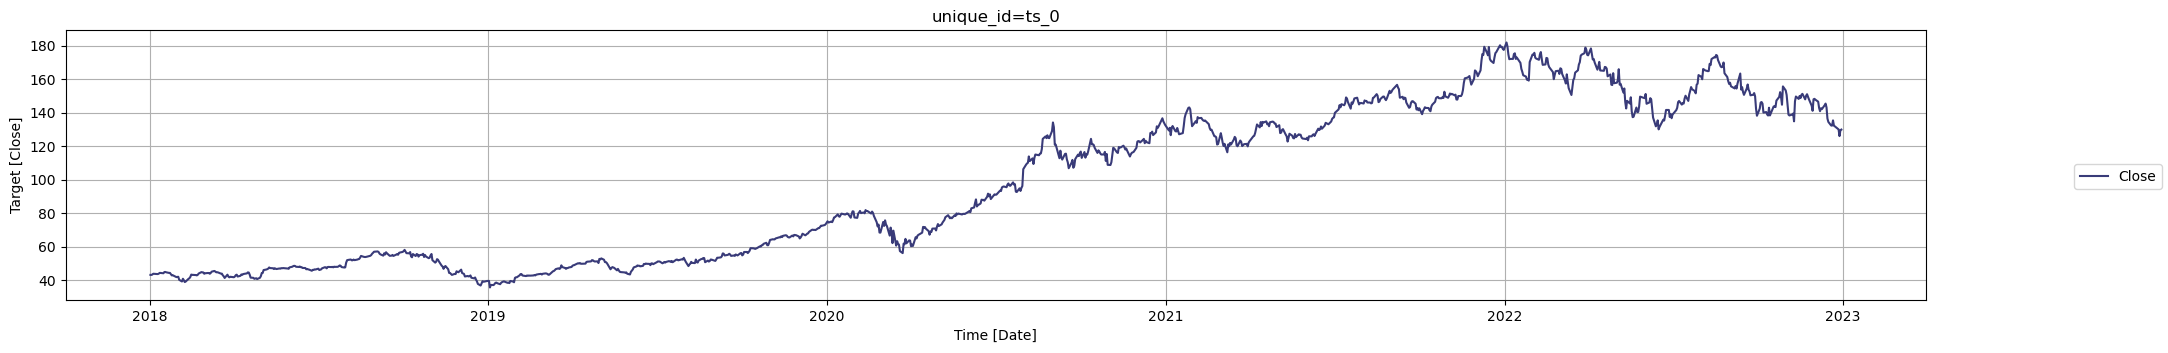

In [7]:
nixtla_client.plot(train_data, time_col='Date', target_col='Close')

In [8]:
data_forecast = nixtla_client.forecast(
    df=train_data,
    h=len(test_data),
    freq='B',
    level=[90],
    finetune_steps=10,
    model='timegpt-1-long-horizon',
    time_col='Date',
    target_col='Close'
)
data_forecast

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Date,TimeGPT,TimeGPT-lo-90,TimeGPT-hi-90
0,2023-01-02,125.832504,122.539568,129.125441
1,2023-01-03,125.347435,120.262322,130.432548
2,2023-01-04,124.147263,117.760000,130.534525
3,2023-01-05,125.224144,119.611252,130.837036
4,2023-01-06,125.429581,118.831736,132.027425
...,...,...,...,...
235,2023-11-27,151.158997,128.499038,173.818955
236,2023-11-28,152.923004,131.696343,174.149665
237,2023-11-29,152.896774,131.772896,174.020653
238,2023-11-30,152.107483,132.830609,171.384357


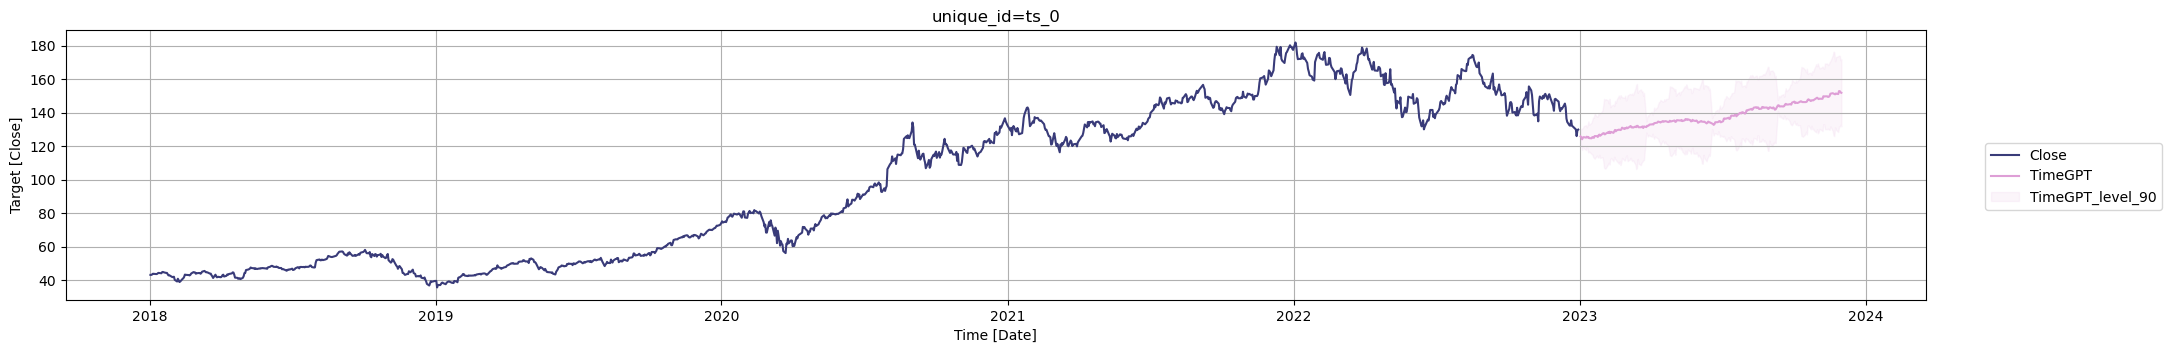

In [9]:
nixtla_client.plot(train_data, data_forecast, models=['TimeGPT'], level=[90], time_col='Date', target_col='Close')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Using the following exogenous variables: Open, High, Low, Adj Close, Volume


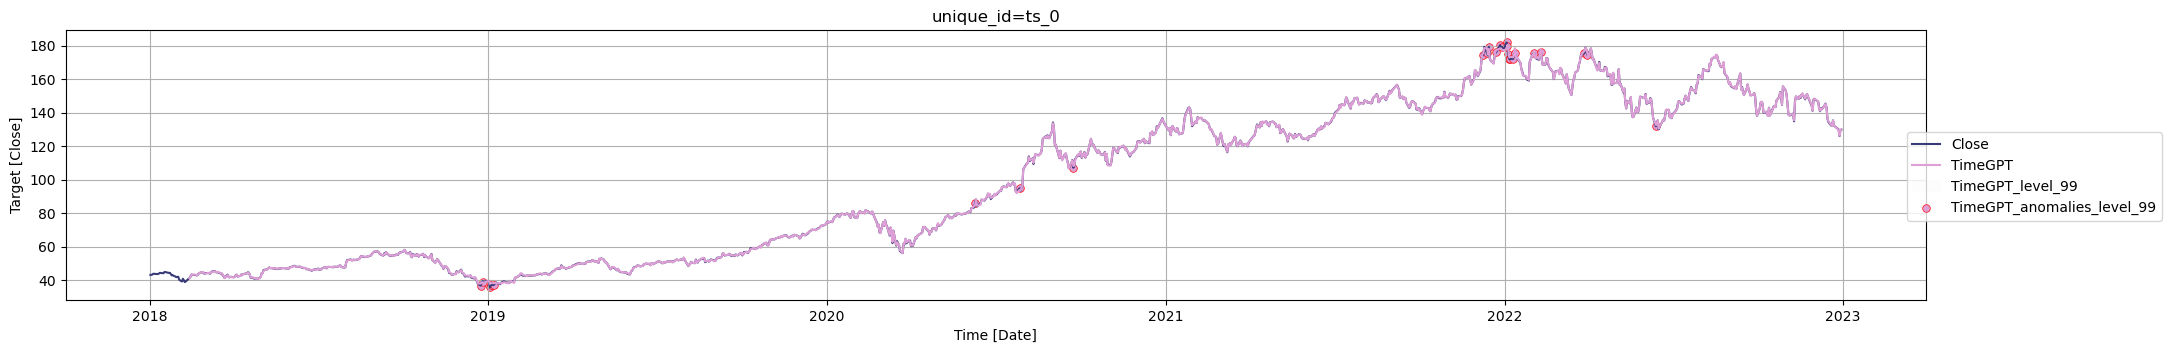

In [10]:
anomalies = nixtla_client.detect_anomalies(train_data, time_col='Date', target_col='Close', freq='B')
nixtla_client.plot(train_data, anomalies, time_col='Date', target_col='Close', plot_anomalies=True)

In [11]:
# Debugging: print the first few rows of data_forecast
print("Forecast data:")
print(data_forecast.head())

# Calculate metrics
rmse = mean_squared_error(test_data['Close'], data_forecast['TimeGPT'], squared=False)
mae = mean_absolute_error(test_data['Close'], data_forecast['TimeGPT'])

# Check for NaN values in data_forecast
if data_forecast['TimeGPT'].isnull().any():
    print("NaN values found in the forecast data")

# Replace zero values in test_data['Close'] with NaN
test_data_non_zero = test_data.copy()
test_data_non_zero['Close'].replace(0, np.nan, inplace=True)

# Drop rows with NaN values resulting from replacement
test_data_non_zero.dropna(subset=['Close'], inplace=True)

# Ensure that the Date column is the same format
data_forecast['Date'] = pd.to_datetime(data_forecast['Date'])
test_data_non_zero['Date'] = pd.to_datetime(test_data_non_zero['Date'])

# Print the first few rows of test_data_non_zero
print("Test data non-zero:")
print(test_data_non_zero.head())

# Align forecasts with the modified test data
aligned_forecast = data_forecast[data_forecast['Date'].isin(test_data_non_zero['Date'])].copy()

# Debugging: print the first few rows of aligned_forecast
print("Aligned forecast data before setting index:")
print(aligned_forecast.head())

# Ensure the indices match
test_data_non_zero.set_index('Date', inplace=True)
aligned_forecast.set_index('Date', inplace=True)

# Debugging: print the first few rows of aligned_forecast after setting index
print("Aligned forecast data after setting index:")
print(aligned_forecast.head())

# Check again for NaN values in the aligned forecast
if aligned_forecast['TimeGPT'].isnull().any():
    print("NaN values found in the aligned forecast data")

# Remove NaN values from aligned_forecast
aligned_forecast.dropna(subset=['TimeGPT'], inplace=True)

# Recalculate MAPE only for the dates that are present in both test_data_non_zero and aligned_forecast
common_dates = test_data_non_zero.index.intersection(aligned_forecast.index)
test_data_non_zero_common = test_data_non_zero.loc[common_dates]
aligned_forecast_common = aligned_forecast.loc[common_dates]

# Debugging: print the first few rows of the common data
print("Common test data:")
print(test_data_non_zero_common.head())
print("Common forecast data:")
print(aligned_forecast_common.head())

# Calculate MAPE
mape = np.mean(np.abs((test_data_non_zero_common['Close'].values - aligned_forecast_common['TimeGPT'].values) / test_data_non_zero_common['Close'].values)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')


Forecast data:
         Date     TimeGPT  TimeGPT-lo-90  TimeGPT-hi-90
0  2023-01-02  125.832504     122.539568     129.125441
1  2023-01-03  125.347435     120.262322     130.432548
2  2023-01-04  124.147263     117.760000     130.534525
3  2023-01-05  125.224144     119.611252     130.837036
4  2023-01-06  125.429581     118.831736     132.027425
Test data non-zero:
           Date        Open        High         Low       Close   Adj Close  \
1259 2023-01-03  130.279999  130.899994  124.169998  125.070000  124.216293   
1260 2023-01-04  126.889999  128.660004  125.080002  126.360001  125.497498   
1261 2023-01-05  127.129997  127.769997  124.760002  125.019997  124.166641   
1262 2023-01-06  126.010002  130.289993  124.889999  129.619995  128.735229   
1263 2023-01-09  130.470001  133.410004  129.889999  130.149994  129.261597   

         Volume  
1259  112117500  
1260   89113600  
1261   80962700  
1262   87754700  
1263   70790800  
Aligned forecast data before setting index:
  

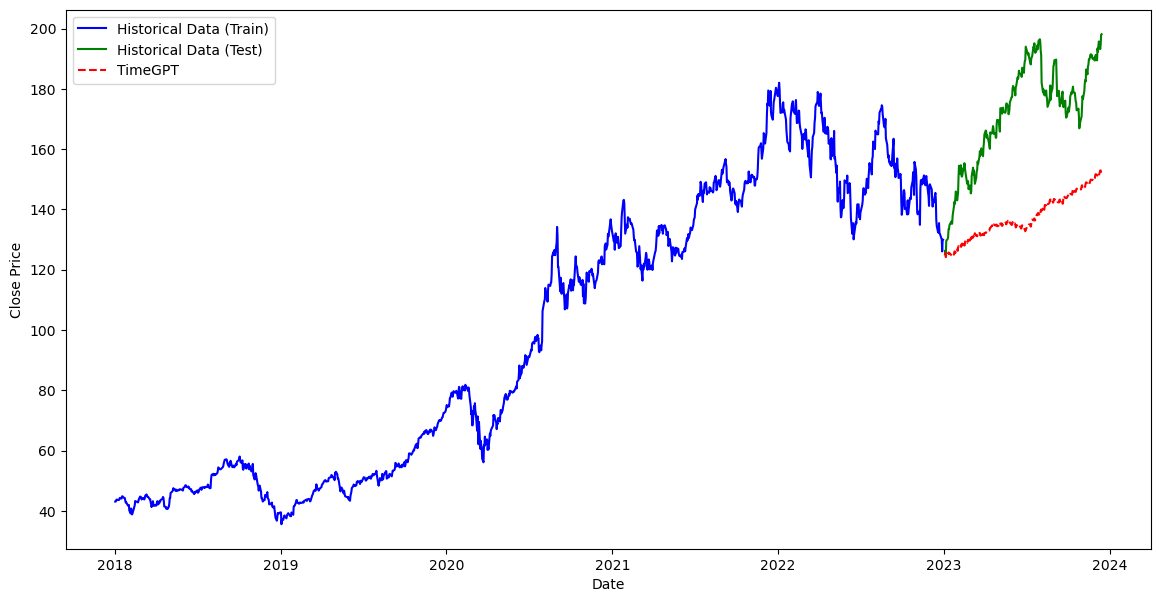

In [12]:
import matplotlib.pyplot as plt

# Визуализация на историческите данни и прогнозата
plt.figure(figsize=(14, 7))
plt.plot(train_data['Date'], train_data['Close'], label='Historical Data (Train)', color='blue')
plt.plot(test_data['Date'], test_data['Close'], label='Historical Data (Test)', color='green')
plt.plot(test_data['Date'], data_forecast['TimeGPT'], label='TimeGPT', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [13]:
highest_forecast_price = data_forecast['TimeGPT'].max()
lowest_forecast_price = data_forecast['TimeGPT'].min()

highest_forecast_date = data.loc[data_forecast['TimeGPT'].idxmax()]['Date']
lowest_forecast_date = data.loc[data_forecast['TimeGPT'].idxmin()]['Date']

print(f"Highest forecasted price: {highest_forecast_price} on {highest_forecast_date}")
print(f"Lowest forecasted price: {lowest_forecast_price} on {lowest_forecast_date}")

Highest forecasted price: 152.92300415039062 on 2018-12-10 00:00:00
Lowest forecasted price: 124.14726257324219 on 2018-01-04 00:00:00
